# Evaluate GloVe Embeddings - Special Investigation
Copyright (C) 2021 ServiceNow, Inc.

Investigate a series of tests for a couple of models including
* nearest neighbours to analogy predictions
* plotting analogy pairs 
* plotting relatedness gradients
* nearest neighbours for acronyms and words with spelling variations

In [1]:
import pathlib
REPO_DIR = pathlib.Path(__name__).parent.absolute().parent.parent
print(REPO_DIR)

import sys
sys.path.append(str(REPO_DIR))

/nrcan_p2/workspace/sraimondo/nrcan_p2_5


Update this folder to point to the output folder which contains the model map which we use to help us load the correct models:

In [2]:
OUTPUT_FOLDER = '/nrcan_p2/data/07_model_output/glove_geology_evaluation/'

## Load all the tests

In [3]:
from nrcan_p2.evaluation.load_test_data import (
    load_analogy_data, load_similarity_data, load_nearest_neighbour_data, load_word_cluster_data)

analogy_tests = load_analogy_data(REPO_DIR / 'nrcan_p2/evaluation/2020_ElementAI_Test_CJML_02_Dec-16-2020 - Analogy.csv')
#analogy_tests = load_analogy_data(REPO_DIR / 'nrcan_p2/evaluation/2020_ElementAI_Test_CJML_03_Feb-23-2020-Analogy.csv')
#
#display(analogy_tests)

Analogy data contains: 66 analogies in 9 themes


In [4]:
relatedness_tests = load_similarity_data(REPO_DIR / 'nrcan_p2/evaluation/2020_ElementAI_Test_CJML_03_Feb-23-2020-Relatedness.csv')
#display(relatedness_tests)

Relatedness data contains: 249 relatedness examples in 14 themes


In [5]:
nn_tests = load_nearest_neighbour_data(REPO_DIR / 'nrcan_p2/evaluation/2020_ElementAI_Test_CJML_03_Jan-4-2020-NearestNeighbours.csv')
#display(nn_tests)

Nearest neighbor data contains: 5 words


In [6]:
cluster_tests = load_word_cluster_data(REPO_DIR / 'nrcan_p2/evaluation/2020_ElementAI_Test_CJML_03_Jan-4-2020-WordClusters.csv')
#display(cluster_tests)

Word cluster data contains: 16 clusters and 900 total words


## Load the models

In [7]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd

MODEL_MAP = pd.read_csv(f'{OUTPUT_FOLDER}/GLOVE_MODEL_MAP.csv')
MODEL_MAP

def get_model_name(pipeline, dataset, name, dim):
    if dim == 300 and name != '6B':
        MODEL_NAME = f'glove.{name}.{pipeline}.{dim}'
    else:
        MODEL_NAME = f'glove.{name}.{pipeline}' 
        
    return MODEL_NAME

def load_model(pipeline, dataset, name, dim, MODEL_MAP):
    
    MODEL_NAME = get_model_name(pipeline, dataset, name, dim) 
    
    if pipeline in ['50d', '300d']:
        GLOVE_MODEL_DIR='/nrcan_p2/data/06_models/glove_pretrained'
       
        #glove.6B.50d.txt')
        glove_file = datapath(f'{GLOVE_MODEL_DIR}/{MODEL_NAME}.txt') #glove.6B.50d.txt')
    else:
        model_row = MODEL_MAP[(MODEL_MAP.dataset == dataset) & (MODEL_MAP.pipeline == pipeline) & 
                              (MODEL_MAP.dim == dim)]
        GLOVE_MODEL_DIR = model_row.path.values[0]
        
        
        glove_file = datapath(f'{GLOVE_MODEL_DIR}/vectors.txt') 
    
    print(GLOVE_MODEL_DIR)

    file_name = pathlib.Path(f"{GLOVE_MODEL_DIR}/word2vec.txt")
    
    if not file_name.exists():
        _ = glove2word2vec(glove_file, file_name)

    model = KeyedVectors.load_word2vec_format(file_name)
    
    return model

In [8]:
model_300d_pretrained = load_model(pipeline='300d', dataset=None, name='6B', dim=300, MODEL_MAP=MODEL_MAP)
#model_300d_v1_ABD = load_model(pipeline='v1', dataset='A full + B + D', name='dA_full_dB_dD', dim=300, MODEL_MAP=MODEL_MAP)
model_300d_PLUS_ABD = load_model(pipeline='PLUS', dataset='A full + B + D', name='dA_full_dB_dD', dim=300, MODEL_MAP=MODEL_MAP)

#pipeline = 'PLUS' # '50d'
#dataset = 'A full + B + D' #'6B'
#name = 'dA_full_dB_dD' #'6B'
#dim = 300
#model_50d_PLUS_ABD = load_model(pipeline='PLUS', dataset='A full + B + D', name='dA_full_dB_dD', dim=50, MODEL_MAP=MODEL_MAP)
#model_300d_80_ABD = load_model(pipeline='80', dataset='A full + B + D', name='dA_full_dB_dD', dim=300, MODEL_MAP=MODEL_MAP)
#model_300d_90_ABD = load_model(pipeline='90', dataset='A full + B + D', name='dA_full_dB_dD', dim=300, MODEL_MAP=MODEL_MAP)


/nrcan_p2/data/06_models/glove_pretrained
/nrcan_p2/data/06_models/glove/dataset_A_full_dB_dD_02-25-2021-01-56-02


## Analogies

In [9]:
analogy_tests

,Task,Theme,a,x,b,y
0,Analogy,Geology,Abitibi,Superior,Stikinia,Cordilleran
1,Analogy,Geology,Core,Mantle,Phenocryst,Rim
2,Analogy,Geology,Core,Inner,Crust,Outer
3,Analogy,Geology,Deposition,Sedimentation,Crystallization,Magmatism
4,Analogy,Geology,Diverging,Ridge,Converging,Mountain
...,...,...,...,...,...,...
61,Analogy,Geology_Petrology_Sedimentary,Turbidite,Marine,Sandstone,Fluvial
62,Analogy,Geology_Structural,Gouge,Unconsolidated,Cataclasite,Consolidated
63,Analogy,Geology_Structural,Norma,Extension,Reverse,Compression
64,Analogy,Geology_Structural,Plunge,Lineation,Strike,Planar


## Nearest neighbours to analogy predictions

Here we investigate the nearest neighbours to the outputs of a few analogy test predictions.
Our goal is to see whether the nearest neighbours are reasonable. The top 1 prediction might not always be perfect, but the top 20 might be reasonable and can give us a better idea of what the model is actually doing.

In [62]:
from nrcan_p2.evaluation.analogies import evaluate_all_analogies, analogy_predict, analogy_distance

test1 = "Deposition	Sedimentation	Crystallization	Magmatism"
test2 = "Magnetite	Magnetic	Graphite	Conductive"
test3 = "Discordant	Dyke	Concordant	Sill"
test4 = "Gneiss	Granite	Marble	Limestone"
test5 = "Shale	Slate	Sandstone	Quartzite"
test6 = "Coarse	Sandstone	Fine	Mudstone"

def get_analogy_comparison(model_300d_pretrained, model_300d_PLUS_ABD, test1, name1, name2, topn=20):
    print(test1)
    dfs = []
    for i,word in enumerate(test1.split()):
        #print(word)
        pre = analogy_predict(model_300d_pretrained, [x.lower() for x in test1.split()], i=i, topn=topn)
        pre.columns= pd.MultiIndex.from_product([[name1], pre.columns])
        other = analogy_predict(model_300d_PLUS_ABD, [x.lower() for x in test1.split()], i=i, topn=topn)
        other.columns= pd.MultiIndex.from_product([[name2], other.columns])

        df = pd.concat([pre, other], axis=1)
        #df.columns = pd.MultiIndex.from_product([[word], df.columns])
        df['word'] = word
        df = df.set_index('word', append=True).unstack('word')
        df.columns = df.columns.swaplevel(0, 2)
        df.columns = df.columns.swaplevel(1, 2)
        
        dfs.append(df)

    x = pd.concat(dfs, axis=1)
    x = x.drop('similarity', axis=1, level=2)
    x = x.droplevel(axis=1, level=2)
    display(x)
    
get_analogy_comparison(model_300d_pretrained, model_300d_PLUS_ABD, test1, name1='Pretrained', name2='A+B+D PLUS')
get_analogy_comparison(model_300d_pretrained, model_300d_PLUS_ABD, test2, name1='Pretrained', name2='A+B+D PLUS')
get_analogy_comparison(model_300d_pretrained, model_300d_PLUS_ABD, test3, name1='Pretrained', name2='A+B+D PLUS')
get_analogy_comparison(model_300d_pretrained, model_300d_PLUS_ABD, test4, name1='Pretrained', name2='A+B+D PLUS')
get_analogy_comparison(model_300d_pretrained, model_300d_PLUS_ABD, test5, name1='Pretrained', name2='A+B+D PLUS')
get_analogy_comparison(model_300d_pretrained, model_300d_PLUS_ABD, test6, name1='Pretrained', name2='A+B+D PLUS')

Deposition	Sedimentation	Crystallization	Magmatism


word      Deposition                    Sedimentation                 \
          Pretrained         A+B+D PLUS    Pretrained     A+B+D PLUS   
0        evaporation         deposition   depositions  sedimentation   
1         filtration       depositional     affidavit      volcanism   
2     eutrophication       accumulation    videotaped      tectonism   
3         solubility           suggests         sworn      deposited   
4          diffusion            suggest           cvd        rifting   
5           sediment        equilibrium         taped        fluvial   
6         nucleation         suggesting     testified   depositional   
7           crystals  recrystallization       perjury      tectonics   
8          carbonate             result       mugnier         basins   
9         fractional         conditions      lewinsky           rift   
10         siltation         indicating          oath        clastic   
11      distillation           settling         tripp      plutonism   
12      permeability           probably       lawsuit       episodes   
13          salinity          deposited    testifying  transgression   
14        extraction             formed     volcanism     widespread   
15        impurities          indicates        martić       tectonic   
16          nutrient       crystallized      unsealed    continental   
17      accumulation           indicate         314.7       orogenic   
18          seawater         diagenesis       muteesa       foreland   
19        adsorption          variation    subpoenaed      subaerial   

word Crystallization                           Magmatism                     
          Pretrained       A+B+D PLUS         Pretrained         A+B+D PLUS  
0         videotaped         magmatic     eutrophication              magma  
1        depositions        volcanism          siltation             magmas  
2           lewinsky      emplacement    crystallisation        emplacement  
3          affidavit        plutonism        erythrocyte           magmatic  
4               oath         emplaced         nucleation      fractionation  
5         testifying           coeval        evaporation             zircon  
6              taped          rifting        percolation    crystallisation  
7              sworn           magmas           salinity  recrystallization  
8          testimony           timing         filtration       crystallized  
9         confession         episodes       flocculation         fractional  
10         testified     mineralizing            silting               ages  
11        affidavits         orogenic         solubility             phases  
12           testify      collisional       palatability          evolution  
13           muteesa       intrusions  multi-dimensional              melts  
14           accuser      extensional       salinization            cooling  
15     indeterminism     metasomatism     solidification          intrusion  
16           videoed               ma         by-product           parental  
17            taping       associated       vaporization    differentiation  
18           heirens       protracted      extravasation       metamorphism  
19          baraguey  contemporaneous          turbidity        progressive

Magnetite	Magnetic	Graphite	Conductive


word    Magnetite                   Magnetic                        Graphite  \
       Pretrained  A+B+D PLUS     Pretrained       A+B+D PLUS     Pretrained   
0            rods   magnetite          fe3o4        resistive      silicates   
1          shafts    hematite       hematite        conductor         silica   
2        titanium      garnet       lamellae         magnetic       sulfides   
3         reactor        iron        ionized       conductors      cementite   
4        reactors        mica   paramagnetic        anomalies     carbonates   
5         neutron     renfrew      two-layer          anomaly      polymeric   
6       compasses    corundum       limonite      resistivity        fibrils   
7          cobalt       grade         silica     magnetically      insoluble   
8           cores      marble       motility           bodies       granules   
9      magnetized   following           ions       overburden       oxidised   
10      resonance  separation      non-metal     conductivity    plagioclase   
11       tungsten      second   field-effect    magnetization  orthopyroxene   
12          shaft       flake         p-type       conducting        sulfide   
13    geomagnetic    feldspar       sulfides           detect          fe3o4   
14        nuclear    ilmenite     rare-earth       alteration           nacl   
15      plutonium    produced  sensorineural        anomalous       oxidized   
16      stainless     apatite       neoplasm        permeable  metamorphosed   
17          scans  containing         n-type  titanomagnetite        calcite   
18           iron      pyrite     ionization         contrast   non-metallic   
19       turbines        talc     dielectric         response         pyrite   

word                   Conductive                   
          A+B+D PLUS   Pretrained       A+B+D PLUS  
0           hematite   electrodes  electromagnetic  
1          sulphides   electrical         airborne  
2       disseminated  transformer      geophysical  
3         pyrrhotite      reactor        anomalies  
4             pyrite     reactors          surveys  
5     disseminations      optical       derivative  
6          graphitic      cooling          anomaly  
7           graphite        laser          gravity  
8           chlorite      thermal               em  
9       chalcopyrite    generator       electrical  
10            lenses        coils         vertical  
11         resistive      magnets           survey  
12        sphalerite     electric              vlf  
13          sericite         coil         residual  
14           epidote      sensors       conductors  
15          veinlets      surface     aeromagnetic  
16       mineralized       device            field  
17          sulphide         uses     coefficients  
18            layers      nuclear      gradiometer  
19            occurs      devices          keating

Discordant	Dyke	Concordant	Sill


word       Discordant                       Dyke                 Concordant  \
           Pretrained    A+B+D PLUS   Pretrained   A+B+D PLUS    Pretrained   
0       sharp-tongued    discordant      detrick        sills     dissonant   
1               quais          ages         fort      diabase       timbres   
2          kaklamanis         dykes  assiniboine       gabbro       muffled   
3         homophonous        zircon        judee         dike    resonating   
4           motorways     concordia      wingate        dikes        tajura   
5             dunnart     foliation       parkus    intrusion   cacophonous   
6            hrothgar         207pb          hap         dyke  imprecations   
7            140-page  granodiorite      rosalie        dykes         2,919   
8               waker            ma      meacham   intrusions         22-28   
9     unauthenticated           age      bellows     gabbroic     mealtimes   
10      solid-colored         206pb         wail    nipissing          jamb   
11            cenotes       zircons       lintel    intrusive       droning   
12          tarmacked      youngest        kiowa      intrude      canizaro   
13           footpath   overlapping      bhushan    intruding     plaintive   
14          extranets       fabrics        grohl      chilled     accenting   
15           brownout   leucocratic      goodrum     intruded       weirdly   
16         sunbathers       plutons      sandbag     intrudes     thrumming   
17             beuren       biotite       heiman   granophyre      textures   
18               irfu       younger      eyebrow  lamprophyre    vocalizing   
19         three-lane      gneissic     planking      diorite   landfalling   

word                           Sill                
           A+B+D PLUS    Pretrained    A+B+D PLUS  
0          concordant          ness         dykes  
1               sills         dykes          dike  
2               207pb   störtebeker         dikes  
3           intercept          offa          sill  
4       disconcordant        acland       diorite  
5               206pb       vechten       diabase  
6       subconcordant      motorway   lamprophyre  
7           concordia        beuren          cuts  
8       metasediments      footpath      intruded  
9         conformable          lane        gabbro  
10            zircons      turnpike         swarm  
11     semiconcordant      bus-only  granodiorite  
12           gabbroic  overspeeding        bodies  
13         stratiform   huckleberry     intrusive  
14        discordance    nibelungen        aplite  
15          discordia           a51        quartz  
16          interflow      nostrand       exposed  
17               mswd          dike         sills  
18    metasedimentary        houten      andesite  
19          kammikivi           wui     pegmatite

Gneiss	Granite	Marble	Limestone


word       Gneiss                         Granite                      Marble  \
       Pretrained       A+B+D PLUS     Pretrained   A+B+D PLUS     Pretrained   
0        pedestal           gneiss    sedimentary     gneisses         schist   
1          statue         granitic         schist   limestones    sedimentary   
2        monument         granites       granitic         beds    metamorphic   
3         statues         gneissic       outcrops  crystalline     limestones   
4         obelisk        pegmatite    metamorphic         seen       granitic   
5         adorned     granodiorite      quartzite         dark      quartzite   
6          carved        granitoid    precambrian       places       gneisses   
7           stone         gneisses     sandstones         grey     sandstones   
8        engraved          biotite       gneisses    evidently      overlying   
9        polished       paragneiss     limestones     gneissic  metamorphosed   
10      headstone      amphibolite        igneous      exposed       mudstone   
11           slab       pegmatitic      sandstone      granite    precambrian   
12       gleaming  metasedimentary         basalt       masses        schists   
13       sculpted          syenite      sediments      contact      sandstone   
14         plaque             pink      overlying      diorite       outcrops   
15         inlaid         tonalite          soils       bedded  carboniferous   
16    countertops         foliated  carboniferous    irregular         facies   
17       fountain     leucogranite    proterozoic   hornblende      sediments   
18      inscribed    metasediments     ordovician     granitic     calcareous   
19      sculpture        monzonite       devonian         rock      mudstones   

word                 Limestone              
         A+B+D PLUS Pretrained  A+B+D PLUS  
0        limestones      stone       stone  
1         dolomitic      brick     marbles  
2       crystalline     statue   limestone  
3            bedded  limestone      quarry  
4     fossiliferous   monument    quarries  
5        calcareous     carved    quarried  
6       interbedded      walls  ornamental  
7          dolomite    erected   dimension  
8            marble     facade        talc  
9              beds    statues       slate  
10           impure       slab    granites  
11     argillaceous   sculpted    calcitic  
12           thinly  staircase   quartzite  
13             lime     plaque        pink  
14             limy   pedestal    building  
15            shaly   fountain   dolomitic  
16         gneisses     wooden  decorative  
17             dark    adorned    dolomite  
18             grey  sandstone       madoc  
19        interbeds  sculpture        mica

Shale	Slate	Sandstone	Quartzite


word        Shale                      Slate                  Sandstone  \
       Pretrained    A+B+D PLUS   Pretrained    A+B+D PLUS   Pretrained   
0           brick         shale        chert         slate        chert   
1       limestone     siltstone     fracking    quartzites     outcrops   
2         granite    sandstones      lignite        schist    siltstone   
3           stone         shaly     phyllite     argillite  sedimentary   
4          facade      mudstone       schist      phyllite     mudstone   
5          marble        shales    siliceous     micaceous   sandstones   
6            tile          grey      shinumo        impure    underlain   
7            gray           bed    marcellus     siliceous    sandstone   
8            roof   interbedded      bitumen          dark   limestones   
9           walls  conglomerate       mancos     graphitic  precambrian   
10         ashlar         stone    magnetite       schists     silurian   
11         slates          beds  precambrian     limestone   calcareous   
12         stucco      greenish  metamorphic  argillaceous    overlying   
13        columns          fine    siltstone    quartzitic       schist   
14          tiled       grained       gneiss     greywacke       gneiss   
15         quarry          dark    diatomite        slates   ordovician   
16        facades        bedded     dolomite    calcareous     granitic   
17      structure           red    underlain        shales      permian   
18    rectangular  carbonaceous   high-grade       fissile     dolomite   
19           wood    calcareous     traprock         black    sediments   

word                Quartzite                 
        A+B+D PLUS Pretrained     A+B+D PLUS  
0        sandstone    granite      quartzite  
1        siltstone     ashlar   conglomerate  
2           shales      brick      greywacke  
3     argillaceous      stone           grit  
4        interbeds  limestone         slates  
5             grey     facade         arkose  
6       calcareous     marble      argillite  
7      interbedded      tiled     quartzites  
8            silty    facades          slaty  
9            shaly     slates      quartzose  
10            beds     façade     sandstones  
11       formation     stucco        arkosic  
12           thick      walls          wacke  
13            dark    mansard  conglomerates  
14      underlying  stonework      schistose  
15       uppermost     arched     quartzitic  
16       overlying   quarried         schist  
17       dolomitic  brickwork         pebbly  
18        mudstone       tile        granite  
19       limestone    cornice         bedded

Coarse	Sandstone	Fine	Mudstone


word         Coarse                 Sandstone                       Fine  \
         Pretrained  A+B+D PLUS    Pretrained     A+B+D PLUS  Pretrained   
0             glass      coarse     siltstone      siltstone     coarser   
1             brick     grained    sandstones    interbedded     grained   
2           granite  sandstones     mudstones  conglomeratic   siltstone   
3         sculpture       finer     zechstein   conglomerate    coarsely   
4            marble     coarser     overlying      mudstones      crumbs   
5       magnificent        sand      overlain         pebbly   zechstein   
6               art      medium  fine-grained      sandstone   reflexion   
7             stone        grey    limestones      interbeds      kosher   
8     architectural    material         silty      laminated     boorish   
9          building   generally   sedimentary         pebble   sandpaper   
10             well        thin    calcareous        arenite     clastic   
11        limestone       stone        pebbly         bedded  effeminate   
12       decorative    granular     greywacke    crossbedded  siltstones   
13     architecture        seen     quartzite       overlain      louche   
14         imposing       sands     underlain        arkosic     raunchy   
15        beautiful    greenish       clastic     polymictic   profanity   
16         painting     usually          marl     siltstones      mussed   
17            walls      quartz        gabbro   argillaceous       silty   
18            built     consist     siliceous    bioturbated   mudstones   
19            works        rock   interbedded      overlying     urchins   

word                      Mudstone                
         A+B+D PLUS     Pretrained    A+B+D PLUS  
0           grained      limestone     siltstone  
1              fine        granite    sandstones  
2           coarser         marble         shale  
3         laminated          brick      mudstone  
4            medium       building          grey  
5       interbedded  architectural  argillaceous  
6             finer         facade         shaly  
7     predominantly    magnificent  carbonaceous  
8           locally          stone          thin  
9           massive          walls   interbedded  
10           bedded     romanesque         silty  
11    coarsegrained      buildings    calcareous  
12           finely   architecture     interbeds  
13         consists        mansion       grained  
14         commonly        statues        bedded  
15           thinly      monuments        shales  
16          consist         façade         thick  
17      finegrained          built          beds  
18     interlayered       historic          dark  
19          laminae         museum     laminated

Repeat, but let's compare between the 50d and 300d models: 

In [64]:
test1 = "Magnetite	Magnetic	Graphite	Conductive"
test2 = "Eruption	Volcano	Wave	Tsunami"
test3 = "Gouge	Unconsolidated	Cataclasite	Consolidated"

with pd.option_context('max_rows', None):
    get_analogy_comparison(model_50d_PLUS_ABD, model_300d_PLUS_ABD, test1, '50d', '300d',topn=100)
get_analogy_comparison(model_50d_PLUS_ABD, model_300d_PLUS_ABD, test2, '50d', '300d')
get_analogy_comparison(model_50d_PLUS_ABD, model_300d_PLUS_ABD, test3, '50d', '300d')
# get_analogy_comparison(model_50d_PLUS_ABD, model_300d_PLUS_ABD, test4)
# get_analogy_comparison(model_50d_PLUS_ABD, model_300d_PLUS_ABD, test5)
# get_analogy_comparison(model_50d_PLUS_ABD, model_300d_PLUS_ABD, test6)

Magnetite	Magnetic	Graphite	Conductive


word    Magnetite                        Magnetic                    \
              50d          300d               50d              300d   
0            mica     magnetite         conductor         resistive   
1       magnetite      hematite        conductors         conductor   
2         renfrew        garnet         signature          magnetic   
3        corundum          iron         anomalies        conductors   
4          marble          mica         resistive         anomalies   
5            iron       renfrew           anomaly           anomaly   
6            talc      corundum       resistivity       resistivity   
7        minerals         grade      magnetically      magnetically   
8         mineral        marble    conductivities            bodies   
9            lots     following      conductivity        overburden   
10          madoc    separation                em      conductivity   
11        apatite        second        coincident     magnetization   
12       feldspar         flake            masked        conducting   
13       titanium      feldspar     resistivities            detect   
14     buckingham      ilmenite              lows        alteration   
15     concession      produced          gradient         anomalous   
16          oxide       apatite         anomalous         permeable   
17      nepheline    containing            deeper   titanomagnetite   
18       bancroft        pyrite          magnetic          contrast   
19            lot          talc         spatially          response   
20        pyrites      minerals          variable           altered   
21         county    pyrrhotite         gradients        coincident   
22         silica    occurrence          apparent          hematite   
23         garnet   occurrences         correlate        pyrrhotite   
24             iv   molybdenite            detect       mineralized   
25       reported    hornblende         typically                em   
26     pyrrhotite      fluorite   topographically         localized   
27        quarter         field         localized            weakly   
28           pure  titaniferous       anomalously         sulphides   
29      commodity      silicate        variations           layered   
30        syenite         taken    susceptibility         unaltered   
31         quartz      titanium  susceptibilities              dike   
32        product        quartz      acoustically          sulphide   
33             vi      crystals        controlled     discontinuous   
34           half    production          profiles        surrounded   
35       produced         oxide    configurations  susceptibilities   
36       crystals  aeromagnetic   discontinuities       anomalously   
37             co       mineral          seafloor        relatively   
38         algoma      reported          discrete             dikes   
39           inch       company            linear       effectively   
40       hematite            18        delineated          remanent   
41           cent       shipped   inhomogeneities            masked   
42    molybdenite       diamond            depths    conductivities   
43     phlogopite           ray   electromagnetic       homogeneous   
44        shipped       gravity        detectable         fractures   
45          gives          tons        continuity         generally   
46       ilmenite        gneiss       distinguish            layers   
47      phosphate        colour         permeable      disseminated   
48            vii       andiron         amplitude   electromagnetic   
49        percent      analysis     configuration     serpentinized   
50    preliminary        survey       surrounding             zones   
51         nickel      products          coincide     resistivities   
52          stone       biotite       conductance              body   
53             31            32              efmy         hematitic   
54           spar     pu

Eruption	Volcano	Wave	Tsunami


word       Eruption                        Volcano                       Wave  \
                50d          300d              50d         300d           50d   
0           beneath      volcanic        eruptions    eruptions    inundation   
1              flow     volcanoes             etna  shinmoedake      tsunamis   
2             wedge    dominantly        stromboli      volcano        surges   
3          basaltic          vent          volcano    volcanoes    earthquake   
4             flows   pyroclastic        volcanoes   subplinian        floods   
5              lava     dominated      shinmoedake    novarupta        hazard   
6        transition      eruption     catastrophic      erupted    triggering   
7       interpreted        active          erupted   vourvoulos       warning   
8            mantle   interpreted  phreatomagmatic     tsunamis     disasters   
9        continuous     subaerial        disasters  bardarbunga         surge   
10         volcanic        felsic       subplinian     effusion   earthquakes   
11          layered       beneath         tsunamis       ontake     triggered   
12      pyroclastic      basaltic       tungurahua   earthquake      disaster   
13            crust  intermediate         effusive   tungurahua         flood   
14           crater    subaqueous         outburst    triggered         runup   
15    characterized     volcanism          surtsey  benmoreitic        storms   
16         thinning          lava         storegga        kelut  catastrophic   
17             arcs       edifice    theistareykir     eruptive    recurrence   
18      sedimentary     sequences           ontake    kirishima     scenarios   
19            domes      velocity        minahassa       katmai        happen   

word                  Tsunami                 
             300d         50d           300d  
0        tsunamis       waves          waves  
1      inundation     seismic       velocity  
2      earthquake    acoustic     reflection  
3           runup  reflection        seismic  
4         warning    velocity     velocities  
5           event      seabed          shear  
6           flood  refraction  compressional  
7        disaster   profiling      nearshore  
8          hazard  velocities        ripples  
9       triggered    currents          tidal  
10      scenarios       slope     amplitudes  
11          waves     shallow     refraction  
12          storm  underwater      amplitude  
13     simulation    seafloor       acoustic  
14         storms  horizontal    reflections  
15      magnitude    profiles      shoreline  
16           wave    sounding        shallow  
17         floods      linear          delta  
18    propagation     beneath   horizontally  
19    earthquakes  reflectors          beach

Gouge	Unconsolidated	Cataclasite	Consolidated


word              Gouge                   Unconsolidated                  \
                    50d              300d            50d            300d   
0         translational   pseudotachylyte    underground           shaft   
1           kettledrums          mylonite      hollinger            foot   
2         retrogressive         mylonitic       property           mines   
3          cataclasites  ultracataclasite         mining         limited   
4         ultramylonite     protomylonite           gold        workings   
5          retrogressed     ultramylonite         cobalt        property   
6         olistostromes      cataclasites          shaft            feet   
7     palaeogroundwater   pseudotachylite       drilling      properties   
8       pseudotachylyte             gouge        limited          little   
9              lozenges   calcitecemented       workings       adjoining   
10               gravai      anastomosing          claim            sunk   
11     ultracataclasite       cataclastic          holds          inches   
12               slumps         mylonites     properties            gold   
13        rumblingnoise    tourmalinerich           teck            vein   
14            metabasic      ofultramafic         shafts          silver   
15              boudins              jint         silver  unconsolidated   
16      porphyroclastic               4bl           sunk         fissure   
17            interlain           kuckaus      paymaster           claim   
18            agmatites         corridors      syndicate     underground   
19        interlayering          cevering         claims     encountered   

word   Cataclasite                    Consolidated                 
               50d          300d               50d           300d  
0        bankfield       sheared  undifferentiated       cevering  
1        hollinger  slickensided         colluvial        fluvial  
2       hargreaves          vein     glaciofluvial    transported  
3          tombill         shaft  glaciolacustrine  accumulations  
4        trethewey    hargreaves               gfc       reworked  
5             vein     hollinger        diamictons  fluvioglacial  
6          jinshan        keeley        glacigenic       alluvium  
7        sylvanite          teck        subaqueous      colluvial  
8         ankerite      workings      glaciomarine       terrains  
9           leemac         veins          morainal      colluvium  
10          valloc     stringers            veneer        clastic  
11          bouzan      shearing            glacio      lithified  
12          siscoe       fissure               gfh      surficial  
13        cadillac          adit      resedimented          sands  
14          empire         fault         surficial  glaciofluvial  
15         canadel         mines           wasting    sedimentary  
16         macassa  slickensides          reworked     alluvially  
17          moneta        silver        stratified      reworking  
18    slickensided        shoots        lacustrine       deposits  
19            gold     sylvanite         landforms     lacustrine

## Nearest Neighbours
Get the nearest neighbours for a couple of words.

In [26]:
from nrcan_p2.evaluation.nearest_neighbours import nearest_neighbour_predict
nns_300d_pretrained = nearest_neighbour_predict(model_300d_pretrained, word='eruption', k=10)
display(nns_300d_pretrained)

nns_300d_plus_adb = nearest_neighbour_predict(model_300d_PLUS_ABD, word='eruption', k=10)
display(nns_300d_plus_adb)

,nn,similarity
0,eruptions,0.780973
1,volcano,0.742967
2,volcanic,0.682735
3,erupting,0.589767
4,lava,0.575599
5,merapi,0.552773
6,mayon,0.522583
7,volcanoes,0.516532
8,vesuvius,0.512138
9,pinatubo,0.510648


,nn,similarity
0,eruptions,0.785322
1,volcano,0.649022
2,explosive,0.580132
3,volcanoes,0.578895
4,eruptive,0.576127
5,erupted,0.562148
6,lava,0.552234
7,magma,0.535883
8,volcanism,0.522992
9,basaltic,0.520297


## Plot analogies
Here we try to investigate a couple of analogies and the nearest neighbours to the models' predictions.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [36]:
def show_pca_plot(l1, DIMS, model, WIDTH=20, HEIGHT=5, TEXTSIZE=12, groups=None, draw_pair_lines=False):
    embs = [model[x.lower().strip()] if type(x) == str else [model[xx.lower().strip()] for xx in x] 
            for x in l1 if type(x) == str and x.lower().strip() in model 
            or type(x) ==list and all([xx.lower().strip() in model for xx in x])]

    names = [x for x in l1 if type(x) == str and x.lower().strip() in model
            or type(x) == list and all([xx.lower().strip() in model for xx in x])]

    groups = [groups[i] for i,x in enumerate(l1) if type(x) == str and x.lower().strip() in model
            or type(x) == list and all([xx.lower().strip() in model for xx in x])]

    embs = [np.expand_dims(emb, axis=1) if type(emb) != list else 
            np.expand_dims(np.mean(np.concatenate([np.expand_dims(x, axis=1) for x in emb], axis=1), axis=1), axis=1) for emb in embs]

    embs_arr = np.concatenate(embs, axis=1)
    print(embs_arr.shape)

    try:
        pca = PCA(n_components=2)
        X = pca.fit(embs_arr.transpose()).transform(embs_arr.transpose())
    except Exception as e:
        return 

    display(X.shape)
    X[:,0].shape

    plt.figure(figsize = (WIDTH,HEIGHT))
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2

    if DIMS == 1:
        y = np.zeros(shape=X.shape[0])
        #xytexty = lambda x: -WIDTH-((WIDTH/2-x)%WIDTH/2)*WIDTH/2
        #xytexty = lambda x: WIDTH - (i%2)*WIDTH/2
#         arrowprops=dict(arrowstyle='-', color='black')
#         rotation=0
        xytexty = lambda x: WIDTH - (i%2)*WIDTH/2
        arrowprops=None #dict(arrowstyle='-', color='black')
        rotation=45        
    elif DIMS == 2:
        y = X[:,1]
        xytexty = lambda x: WIDTH - (i%2)*WIDTH/2
        arrowprops=None #dict(arrowstyle='')
        rotation=45
    else:
        raise ValueError()

    if groups is not None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        #if len(groups) > len(colors):
            
        cgroups = [colors[(len(colors) - x) %len(colors)] for x in groups]
        

        plt.scatter(X[:,0], y , alpha=.8, lw=lw, color=cgroups)
        for i in range(0,X.shape[0]-1):
            if cgroups[i] == cgroups[i+1]:
                plt.plot([X[i,0],X[i+1,0]],[y[i],y[i+1]], color=cgroups[i])
    else:
        plt.scatter(X[:,0], y , alpha=.8, lw=lw)
    ax = plt.gca()
    for i, txt in enumerate(names):
        ax.annotate(txt, xy=(X[i,0], y[i]), xycoords='data',
                    xytext=(0,xytexty(i)), rotation=rotation,
                   textcoords='offset points', size=TEXTSIZE,
                   arrowprops=arrowprops)

    #plt.legend(loc='best', shadow=False, scatterpoints=1)
    #plt.title('PCA')

    plt.show()

Plot the predictions for a specific analogy and its nearest neighbours...

['eruption', 'volcano', 'wave', 'tsunami']


(4, 2)

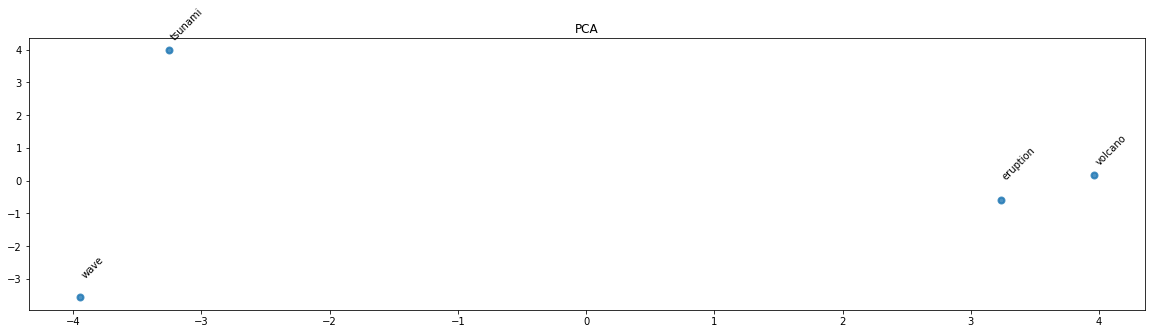

In [21]:
l = ['eruption', 'volcano', 'wave', 'tsunami']
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_pretrained)


['eruption', 'volcano', 'wave', 'tsunami']


(4, 2)

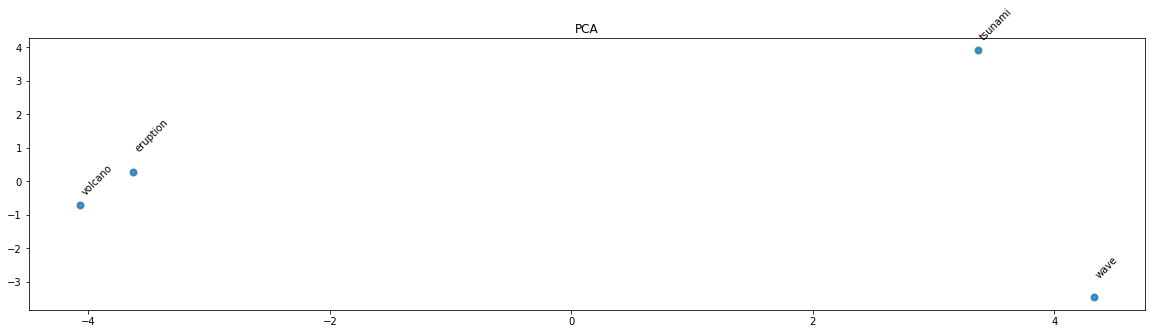

In [22]:
l = ['eruption', 'volcano', 'wave', 'tsunami']
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD)


(40, 2)

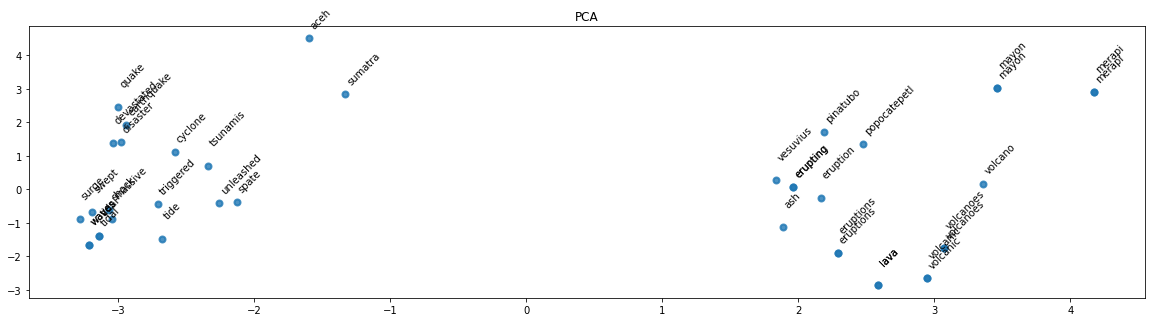

In [30]:
#l = nns_300d_pretrained.nn.values
nns = []
for word in ['eruption', 'volcano', 'wave', 'tsunami']:
    nns.extend(nearest_neighbour_predict(model_300d_pretrained, word=word, k=10).nn.values)
#print(l)
show_pca_plot(nns, DIMS=2, model=model_300d_pretrained)


(40, 2)

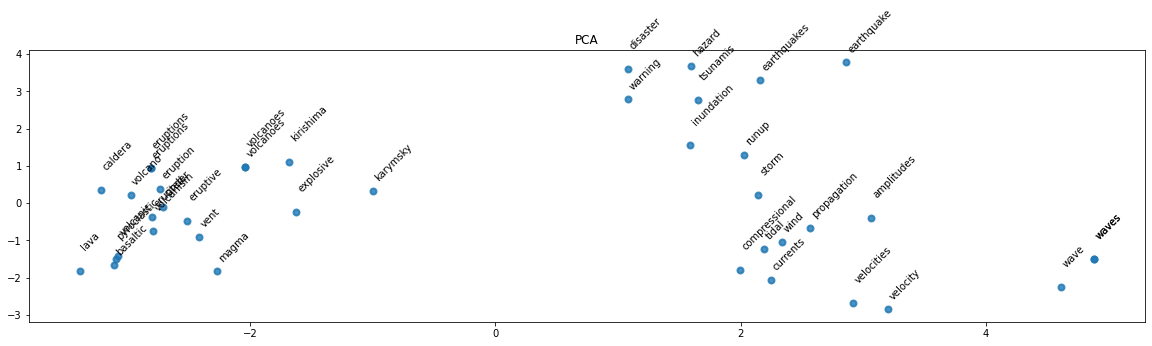

In [31]:
#l = nns_300d_pretrained.nn.values
nns = []
for word in ['eruption', 'volcano', 'wave', 'tsunami']:
    nns.extend(nearest_neighbour_predict(model_300d_PLUS_ABD, word=word, k=10).nn.values)
#print(l)
show_pca_plot(nns, DIMS=2, model=model_300d_PLUS_ABD)


### Plot all analogy pairs in each analogy Theme

Geology


,Task,Theme,a,x,b,y
0,Analogy,Geology,Abitibi,Superior,Stikinia,Cordilleran
1,Analogy,Geology,Core,Mantle,Phenocryst,Rim
2,Analogy,Geology,Core,Inner,Crust,Outer
3,Analogy,Geology,Deposition,Sedimentation,Crystallization,Magmatism
4,Analogy,Geology,Diverging,Ridge,Converging,Mountain
5,Analogy,Geology,Drumlin,Glacier,Scarp,Fault
6,Analogy,Geology,Earth,Planet,Sun,Star
7,Analogy,Geology,Erosion,Sedimentary,Melting,Igneous
8,Analogy,Geology,Fluid,Vein,Magma,Dyke
9,Analogy,Geology,Fossil,Paleontology,Water,Hydrology


(300, 72)


(72, 2)

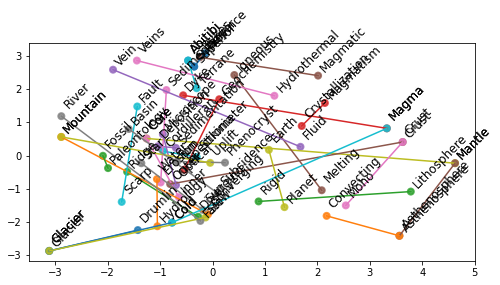

Geology_Geochronology


,Task,Theme,a,x,b,y
18,Analogy,Geology_Geochronology,Archean,Eon,Jurassic,Period
19,Analogy,Geology_Geochronology,Superior,Archean,Grenville,Proterozoic


(300, 8)


(8, 2)

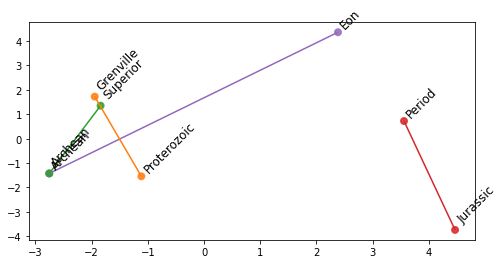

Geology_Hazards


,Task,Theme,a,x,b,y
20,Analogy,Geology_Hazards,Eruption,Volcano,Wave,Tsunami


(300, 4)


(4, 2)

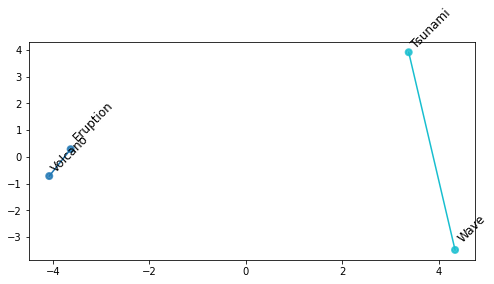

Geology_Metallogeny


,Task,Theme,a,x,b,y
21,Analogy,Geology_Metallogeny,Copper,Porphyry,Lithium,Pegmatite
22,Analogy,Geology_Metallogeny,Gold,Greenstone,Molybdneum,Granite
23,Analogy,Geology_Metallogeny,Gold,Hydrothermal,Nickel,Magmatic
24,Analogy,Geology_Metallogeny,Nickel,Pentlandite,Copper,Chalcopyrite


(300, 15)


(15, 2)

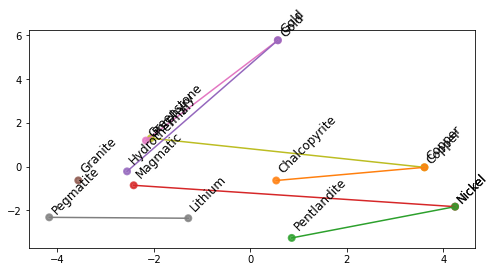

Geology_Mineralogy


,Task,Theme,a,x,b,y
25,Analogy,Geology_Mineralogy,Diamond,Graphite,Kyanite,Sillimanite
26,Analogy,Geology_Mineralogy,Diopside,Pyroxene,Actinolite,Amphibole
27,Analogy,Geology_Mineralogy,Green,Chlorite,Black,Pyroxene
28,Analogy,Geology_Mineralogy,Magnetite,Magnetic,Graphite,Conductive
29,Analogy,Geology_Mineralogy,Magnetite,Oxide,Calcite,Carbonate
30,Analogy,Geology_Mineralogy,Muscovite,Phyllosilicate,Epidote,Sorosilicate
31,Analogy,Geology_Mineralogy,Quartz,Granite,Olivine,Peridotite
32,Analogy,Geology_Mineralogy,Quartz,Silicate,Pentlandite,Sulphide
33,Analogy,Geology_Mineralogy,Sericite,Feldspar,Serpentine,Olivine
34,Analogy,Geology_Mineralogy,Sulphide,Conductive,Granite,Resistive


(300, 43)


(43, 2)

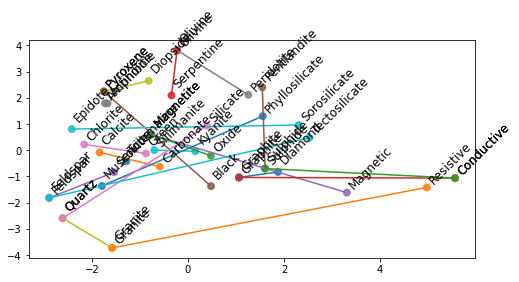

Geology_Petrology_Igneous


,Task,Theme,a,x,b,y
36,Analogy,Geology_Petrology_Igneous,Basalt,Mafic,Rhyolite,Felsic
37,Analogy,Geology_Petrology_Igneous,Basalt,Mafic,Andesite,Intermediate
38,Analogy,Geology_Petrology_Igneous,Basanite,Alkaline,Basalt,Subalkaline
39,Analogy,Geology_Petrology_Igneous,Batholith,Deep,Hypabyssal,Shallow
40,Analogy,Geology_Petrology_Igneous,Cooling,Crystallization,Heating,Melting
41,Analogy,Geology_Petrology_Igneous,Discordant,Dyke,Concordant,Sill
42,Analogy,Geology_Petrology_Igneous,Granite,Intrusive,Rhyolite,Extrusive
43,Analogy,Geology_Petrology_Igneous,Granite,Plutonic,Basalt,Volcanic
44,Analogy,Geology_Petrology_Igneous,Phaneritic,Granite,Aphanitic,Volcanic


(300, 36)


(36, 2)

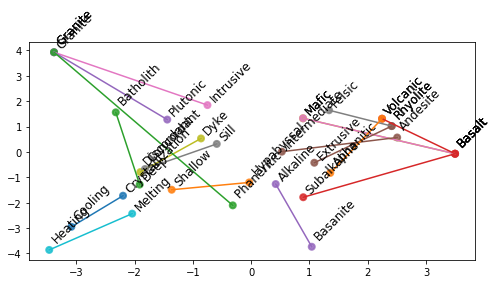

Geology_Petrology_Metamorphic


,Task,Theme,a,x,b,y
45,Analogy,Geology_Petrology_Metamorphic,Albite,Greenschist,Anorthite,Amphibolite
46,Analogy,Geology_Petrology_Metamorphic,Chlorite,Greenschist,Biotite,Amphibolite
47,Analogy,Geology_Petrology_Metamorphic,Foliated,Gneiss,Massive,Granite
48,Analogy,Geology_Petrology_Metamorphic,Gneiss,Granite,Marble,Limestone
49,Analogy,Geology_Petrology_Metamorphic,Granite,Igneous,Gneiss,Metamorphic
50,Analogy,Geology_Petrology_Metamorphic,Granite,Isotropic,Gneiss,Anisotropic
51,Analogy,Geology_Petrology_Metamorphic,Kyanite,Blueschist,Pyroxene,Granulite
52,Analogy,Geology_Petrology_Metamorphic,Kyanite,Metamorphic,Olivine,Igneous
53,Analogy,Geology_Petrology_Metamorphic,Shale,Slate,Sandstone,Quartzite


(300, 36)


(36, 2)

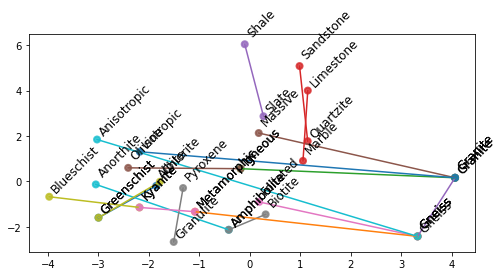

Geology_Petrology_Sedimentary


,Task,Theme,a,x,b,y
54,Analogy,Geology_Petrology_Sedimentary,Angular,Breccia,Rounded,Conglomerate
55,Analogy,Geology_Petrology_Sedimentary,Clay,Shale,Sand,Arenite
56,Analogy,Geology_Petrology_Sedimentary,Coarse,Sandstone,Fine,Mudstone
57,Analogy,Geology_Petrology_Sedimentary,Detritus,Erosion,Rock,Lithification
58,Analogy,Geology_Petrology_Sedimentary,Limestone,Chemical,Sandstone,Clastic
59,Analogy,Geology_Petrology_Sedimentary,Quartz,Sandstone,Feldspar,Arkose
60,Analogy,Geology_Petrology_Sedimentary,Sandstone,Trap,Shale,Source
61,Analogy,Geology_Petrology_Sedimentary,Turbidite,Marine,Sandstone,Fluvial


(300, 32)


(32, 2)

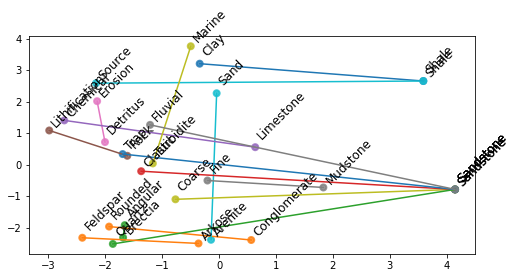

Geology_Structural


,Task,Theme,a,x,b,y
62,Analogy,Geology_Structural,Gouge,Unconsolidated,Cataclasite,Consolidated
63,Analogy,Geology_Structural,Norma,Extension,Reverse,Compression
64,Analogy,Geology_Structural,Plunge,Lineation,Strike,Planar
65,Analogy,Geology_Structural,Transform,Fault,Anticline,Fold


(300, 16)


(16, 2)

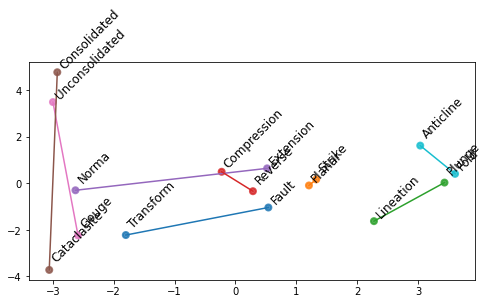

In [188]:
for theme, group in analogy_tests.groupby('Theme'):
    print(theme)
    ls = []
    groups = []
    for irow,row in group.iterrows():
        l = row.iloc[2:].values
        ls.extend(l[0:2])
        groups.extend([irow*2,irow*2])
        ls.extend(l[2:4])
        groups.extend([irow*2+1,irow*2+1])        
        
        #break
    display(group)
    show_pca_plot(ls, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=8, HEIGHT=4, TEXTSIZE=12, groups=groups, draw_pair_lines=True)
    plt.show()

### Plot the specific analogy pairs in the analogy groups test fil

In [57]:
import  re
analogy_group_tests = pd.read_csv(REPO_DIR / 'nrcan_p2/evaluation/2020_ElementAI_Test_CJML_04_Mar-12-2020-Analogy_Groups.csv', header=None)
analogy_group_tests = analogy_group_tests.dropna()
#display(analogy_group_tests)
analogy_group_tests['axby'] = analogy_group_tests[1].apply(lambda x: re.search(r'(.*) is to (.*) as (.*) is to (.*)',x).groups())
analogy_group_tests['a'] = analogy_group_tests.axby.str[0]
analogy_group_tests['x'] = analogy_group_tests.axby.str[1]
analogy_group_tests['b'] = analogy_group_tests.axby.str[2]
analogy_group_tests['y'] = analogy_group_tests.axby.str[3]
analogy_group_tests.columns = ['Group', 'Text', 'quartet', 'a', 'x', 'b','y']
#display(analogy_group_tests)

Analogy Group 1 (Grain size -> Rock type)


,Text
0,Clay is to Claystone as Silt is to Siltstone
1,Sand is to Sandstone as Gravel is to Conglomerate


(300, 8)


(8, 2)

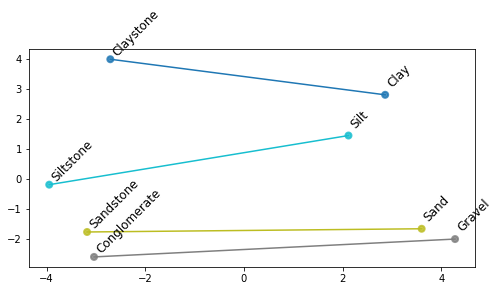

Analogy Group 10 (property -> mineral)


,Text
30,Diamond is to Hard as Magnetite is to Magnetic
31,Gold is to Dense as Graphite is to Conductive
32,Talc is to Soft as Pyrite is to Metallic


(300, 12)


(12, 2)

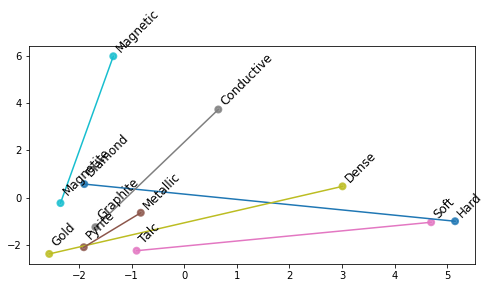

Analogy Group 10b (property -> mineral)


,Text
33,Gold is to Dense as Diamond is to Hard
34,Talc is to Soft as NOTAREALWORD is to NOTAREALWORD


(300, 6)


(6, 2)

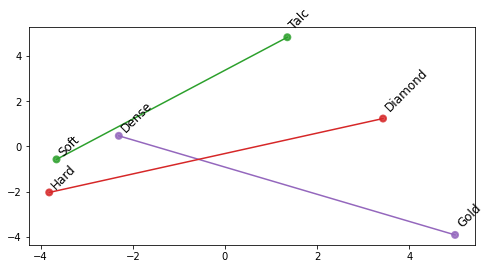

Analogy Group 10c (property -> mineral)


,Text
35,Gaaaold is to NOTAREALWORD as Graphite is to Conductive
36,Magnetite is to Magnetic as Pyrite is to Metallic


(300, 6)


(6, 2)

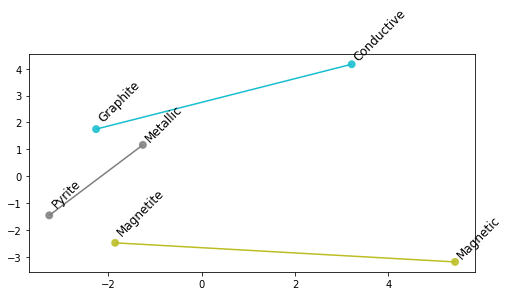

Analogy Group 2 (Rock Classification -> Rock Type)


,Text
2,Gneiss is to Metamorphic as Granite is to Igneous
3,Schist is to Metamorphic as Diorite is to Igneous
4,Phyllite is to Metamorphic as Basalt is to Igneous
5,Sandstone is to Sedimentary as Rhyolite is to Igneous
6,Limestone is to Sedimentary as Mylonite is to Fault


(300, 20)


(20, 2)

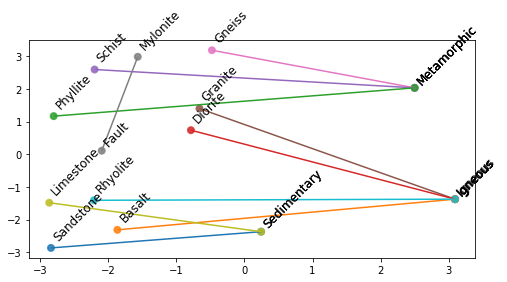

Analogy Group 2b (Rock Classification -> Rock Type)


,Text
7,Gneiss is to Metamorphic as Granite is to Igneous
8,Schist is to Metamorphic as Diorite is to Igneous
9,Phyllite is to Metamorphic as Basalt is to Igneous
10,Sandstone is to Sedimentary as Rhyolite is to Igneous
11,Limestone is to Sedimentary as NOTAREALWORD is to NOTAREALWORD


(300, 18)


(18, 2)

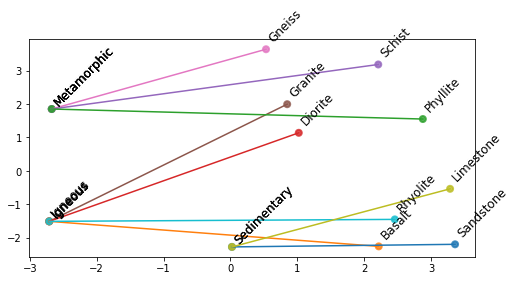

Analogy Group 3 (Economic Element -> Economic Mineral)


,Text
12,Nickel is to Pentlandite as Copper is to Chalcopyrite
13,Molybdenum is to Molybdenite as Zinc is to Sphalerite
14,Uranium is to Uraninite as Lead is to Galena
15,Chrome is to Chromite as Carbon is to Graphite
16,Aluminum is to Bauxite as Tin is to Cassiterite


(300, 20)


(20, 2)

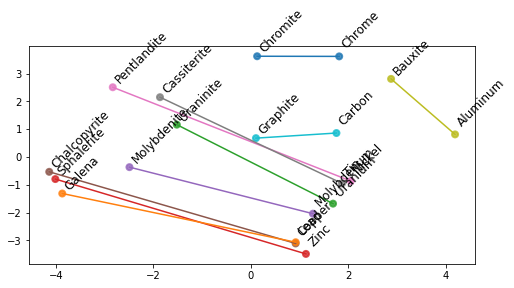

Analogy Group 4 (Fabric -> Rock Type)


,Text
17,Gneissic is to Gneiss as Schistose is to Schist
18,Massive is to Hornfels as Granoblastic is to Granulite


(300, 8)


(8, 2)

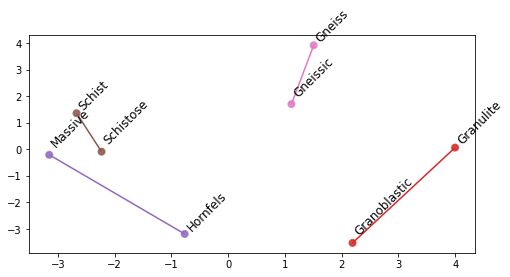

Analogy Group 5 (Protolith -> Metamorphic Rock)


,Text
19,Sandstone is to Quartzite as Limestone is to Marble
20,Basalt is to Amphibolite as Shale is to Slate


(300, 8)


(8, 2)

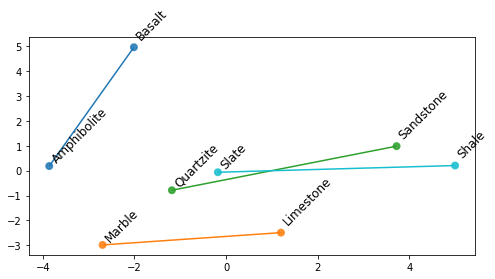

Analogy Group 6 (Type Mineral -> Metamorphic Facies)


,Text
21,Chlorite is to Greenschist as Kyanite is to Blueschist
22,Hornblende is to Amphibolite as Hypersthene is to Granulite


(300, 8)


(8, 2)

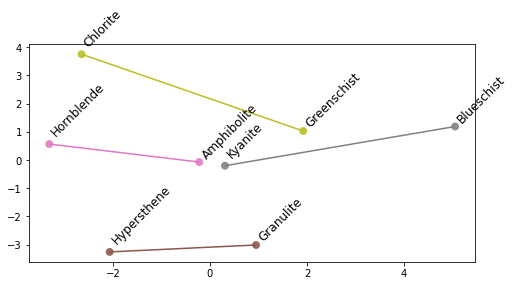

Analogy Group 7 (Type Mineral -> Rock)


,Text
23,Quartz is to Granite as Feldspar is to Arkose
24,Olivine is to Peridotite as Plagioclase is to Diorite


(300, 8)


(8, 2)

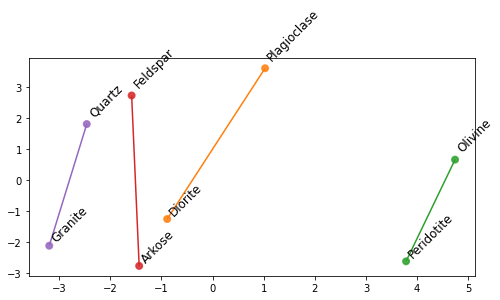

Analogy Group 8 (time scale divisions) 


,Text
25,Cenozoic is to Phanerozoic as Paleoproterozoic is to Proterozoic
26,Paleogene is to Cenozoic as Triassic is to Mesozoic
27,Cambrian is to Paleozoic as Ediacaran is to Precambrian


(300, 12)


(12, 2)

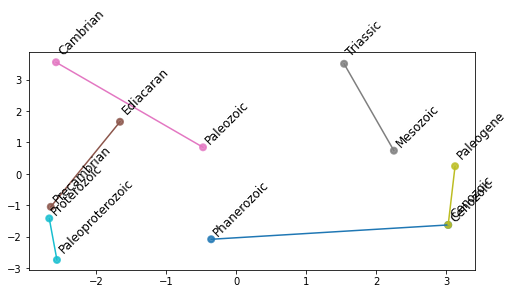

Analogy Group 9 (colour -> mineral)


,Text
28,Blue is to Kyanite as Green is to Chlorite
29,Black is to Pyroxene as Red is to Hematite


(300, 8)


(8, 2)

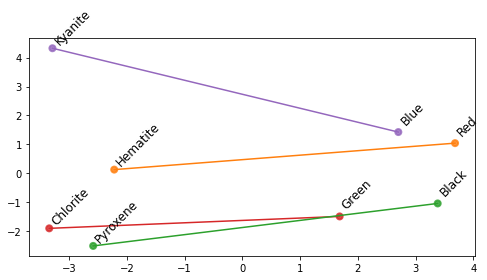

In [59]:
for theme, group in analogy_group_tests.groupby('Group'):
    print(theme)
    ls = []
    groups = []
    for irow,row in group.iterrows():
        l = row.quartet #[2:].values
        ls.extend(l[0:2])
        groups.extend([irow*2,irow*2])
        ls.extend(l[2:4])
        groups.extend([irow*2+1,irow*2+1])        
        
        #break
    with pd.option_context('max_colwidth', None):
        display(group.Text.to_frame())
    #display(group)
    show_pca_plot(ls, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=8, HEIGHT=4, TEXTSIZE=12, groups=groups, draw_pair_lines=True)
    plt.show()

## Relatedness gradients

Investigate model performance on the relatedness gradients. Project the words into 2D and visualize whether or not they lie on the expected gradient

In [74]:
ltype_relatedness = relatedness_tests[relatedness_tests.l.str.len() > 2]
ltype_relatedness.shape

(15, 24)

In [164]:
ltype_relatedness

,Task,Theme,Include synonym,Spelling variation,y,a,x (Words with decreasing similarity ->),Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,l
70,Relatedness,Geology_Geochronology_Eon,No,NaN,NaN,Hadean,Archean,Proterozoic,Phanerozoic,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Hadean, Archean, Proterozoic, Phanerozoic]"
71,Relatedness,Geology_Geochronology_Period,No,NaN,NaN,Eoarchean,Paleoarchean,Mesoarchean,Neoarchean,Paleoproterozoic,...,Silurian,Devonian,Carboniferous,Permian,Triassic,Jurassic,Cretaceous,Paleogene,Neogene,"[Eoarchean, Paleoarchean, Mesoarchean, Neoarch..."
100,Relatedness,Geology_Mineralogy,No,NaN,NaN,Albite,Oligoclase,Andesine,Labradorite,Bytownite,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Albite, Oligoclase, Andesine, Labradorite, By..."
109,Relatedness,Geology_Mineralogy,No,NaN,NaN,Euhedral,Subhedral,Anhedral,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Euhedral, Subhedral, Anhedral]"
130,Relatedness,Geology_Petrology_Igneous,No,NaN,NaN,Komatiite,Basalt,Andesite,Rhyolite,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Komatiite, Basalt, Andesite, Rhyolite]"
133,Relatedness,Geology_Petrology_Igneous,No,NaN,NaN,Lherzolite,Harzburgite,Dunite,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Lherzolite, Harzburgite, Dunite]"
137,Relatedness,Geology_Petrology_Igneous,No,NaN,NaN,Olivine,Pyroxene,Amphibole,Biotite,Anorthite,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Olivine, Pyroxene, Amphibole , Biotite, Anort..."
140,Relatedness,Geology_Petrology_Igneous,No,NaN,NaN,Peridotite,Gabbro,Diorite,Granite,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Peridotite, Gabbro, Diorite, Granite]"
151,Relatedness,Geology_Petrology_Igneous,No,NaN,NaN,Ultramafic,Mafic,Intermediate,Felsic,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Ultramafic , Mafic, Intermediate, Felsic]"
164,Relatedness,Geology_Petrology_Metamorphic,No,NaN,NaN,Greenschist,Amphibolite,Granulite,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Greenschist, Amphibolite, Granulite]"


Geology_Geochronology_Eon
['Hadean', 'Archean', 'Proterozoic', 'Phanerozoic']
(300, 4)


(4, 2)

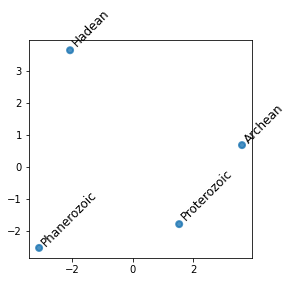

(300, 4)


(4, 2)

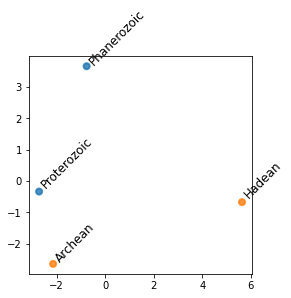

In [163]:
i = 0
l = ltype_relatedness.iloc[i,:].l
print(ltype_relatedness.iloc[i,:].Theme)
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=4, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0,0])
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=4, HEIGHT=4, TEXTSIZE=12, groups=[1,1,0,0])
plt.show()

Geology_Geochronology_Period
['Eoarchean', 'Paleoarchean', 'Mesoarchean', 'Neoarchean', 'Paleoproterozoic', 'Mesoproterozoic', 'Neoproterozoic', 'Cambrian', 'Ordovician', 'Silurian', 'Devonian', 'Carboniferous', 'Permian', 'Triassic', 'Jurassic', 'Cretaceous', 'Paleogene', 'Neogene']
(300, 14)


(14, 2)

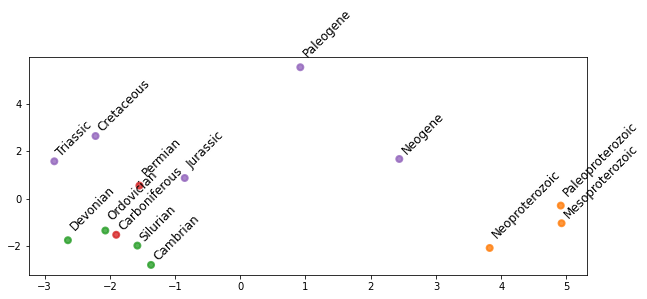

(300, 18)


(18, 2)

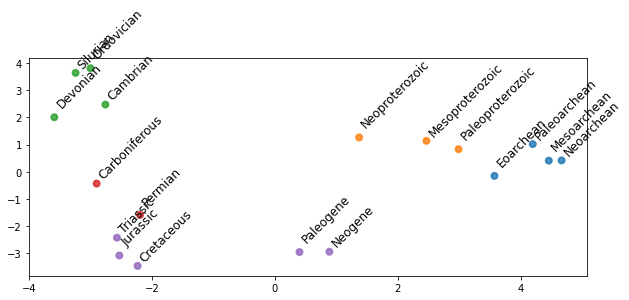

In [162]:
i = 1
l = ltype_relatedness.iloc[i,:].l
print(ltype_relatedness.iloc[i,:].Theme)
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=10, HEIGHT=4, TEXTSIZE=12, groups=[1,1,1,2,2,2,2,3,3,4,4,4,4,4])
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=10, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0,0,1,1,1,2,2,2,2,3,3,4,4,4,4,4])
plt.show()

Geology_Mineralogy
['Albite', 'Oligoclase', 'Andesine', 'Labradorite', 'Bytownite', 'Anorthite']
(300, 3)


(3, 2)

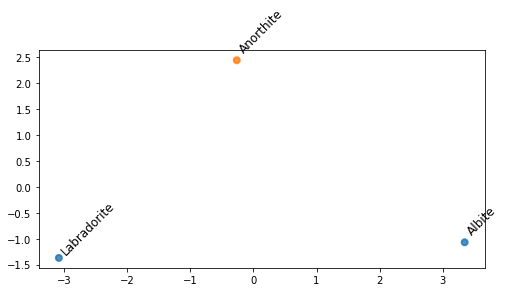

(300, 6)


(6, 2)

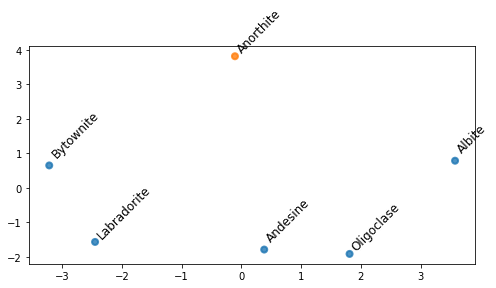

In [155]:
i = 2
l = ltype_relatedness.iloc[i,:].l
print(ltype_relatedness.iloc[i,:].Theme)
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=8, HEIGHT=4, TEXTSIZE=12, groups=[0,0,1])
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=8, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0,0,0,1])
plt.show()

Geology_Mineralogy
['Euhedral', 'Subhedral', 'Anhedral']
(300, 1)
(300, 3)


(3, 2)

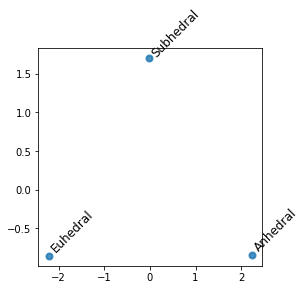

In [152]:
i = 3
l = ltype_relatedness.iloc[i,:].l
print(ltype_relatedness.iloc[i,:].Theme)
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=8, HEIGHT=4, TEXTSIZE=12)
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=4, HEIGHT=4, TEXTSIZE=12)
plt.show()

Geology_Petrology_Igneous
['Komatiite', 'Basalt', 'Andesite', 'Rhyolite']
(300, 4)


(4, 2)

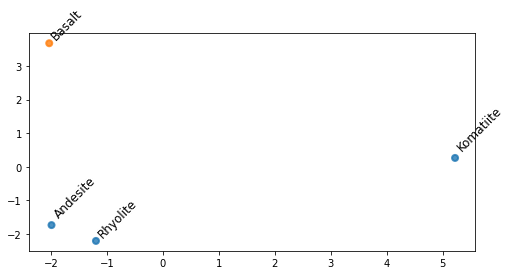

(300, 4)


(4, 2)

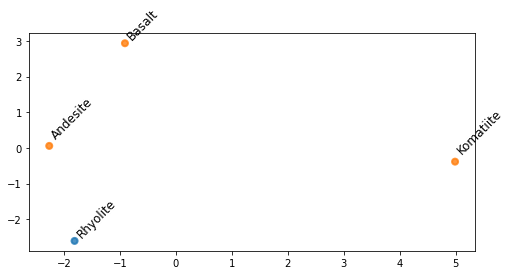

In [150]:
i = 4
l = ltype_relatedness.iloc[i,:].l
print(ltype_relatedness.iloc[i,:].Theme)
print(l)
#l2 = [['ultra', 'mafic'],'mafic', 'intermediate', 'felsic']
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=8, HEIGHT=4, TEXTSIZE=12, groups=[0,1,0,0]) #, groups=[0,0,0,0,0,1,1,1,1])
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=8, HEIGHT=4, TEXTSIZE=12,groups=[1,1,1,0]) #, groups=[0,0,0,1,1,1,1,0,0])#, groups=[0,0,1,0])
plt.show()

Geology_Petrology_Igneous
['Lherzolite', 'Harzburgite', 'Dunite']
(300, 1)
(300, 3)


(3, 2)

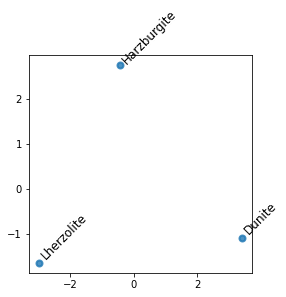

In [149]:
i = 5
l = ltype_relatedness.iloc[i,:].l
print(ltype_relatedness.iloc[i,:].Theme)
print(l)
#l2 = [['ultra', 'mafic'],'mafic', 'intermediate', 'felsic']
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=8, HEIGHT=4, TEXTSIZE=12) #, groups=[0,0,0,0,0,1,1,1,1])
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=4, HEIGHT=4, TEXTSIZE=12) #, groups=[0,0,0,1,1,1,1,0,0])#, groups=[0,0,1,0])
plt.show()

['Olivine', 'Pyroxene', 'Amphibole ', 'Biotite', 'Anorthite', 'Albite', 'Orthoclase', 'Muscovite', 'Quartz']
(300, 9)


(9, 2)

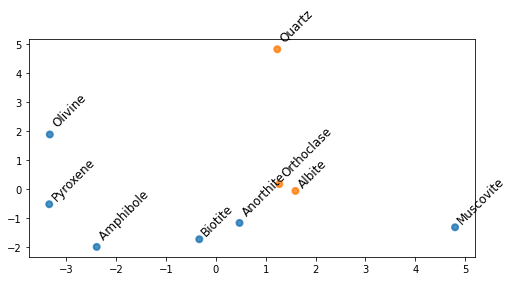

(300, 9)


(9, 2)

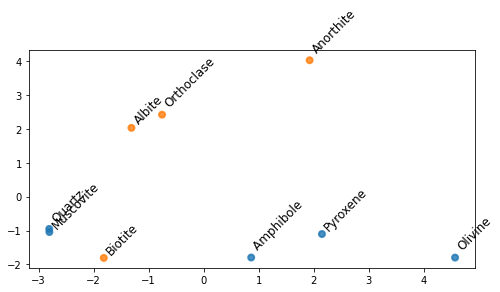

In [145]:
i = 6
l = ltype_relatedness.iloc[i,:].l
print(l)
#l2 = [['ultra', 'mafic'],'mafic', 'intermediate', 'felsic']
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=8, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0,0,0,1,1,1,1])
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=8, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0,1,1,1,1,0,0])#, groups=[0,0,1,0])
plt.show()

['Peridotite', 'Gabbro', 'Diorite', 'Granite']
(300, 4)


(4, 2)

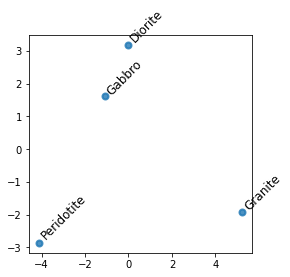

(300, 4)


(4, 2)

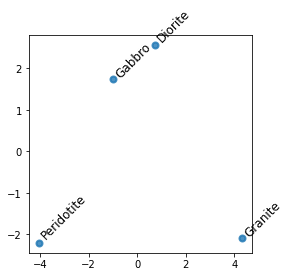

In [136]:
i = 7
l = ltype_relatedness.iloc[i,:].l
print(l)
#l2 = [['ultra', 'mafic'],'mafic', 'intermediate', 'felsic']
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=4, HEIGHT=4, TEXTSIZE=12) #, groups=[0,0,0,0])
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=4, HEIGHT=4, TEXTSIZE=12)#, groups=[0,0,1,0])
plt.show()

['Ultramafic ', 'Mafic', 'Intermediate', 'Felsic']
(300, 4)


(4, 2)

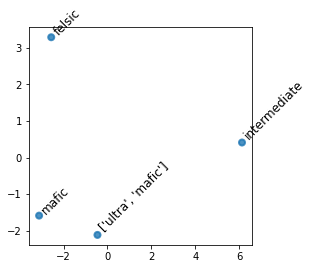

(300, 4)


(4, 2)

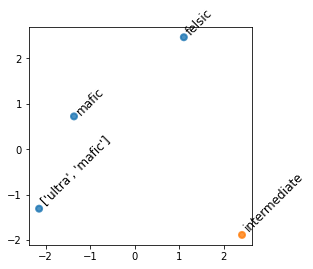

In [135]:
i = 8
l = ltype_relatedness.iloc[i,:].l
print(l)
l2 = [['ultra', 'mafic'],'mafic', 'intermediate', 'felsic']
show_pca_plot(l2, DIMS=2, model=model_300d_pretrained, WIDTH=4, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0,0])
plt.show()
show_pca_plot(l2, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=4, HEIGHT=4, TEXTSIZE=12, groups=[0,0,1,0])
plt.show()

['Greenschist', 'Amphibolite', 'Granulite']


(3, 2)

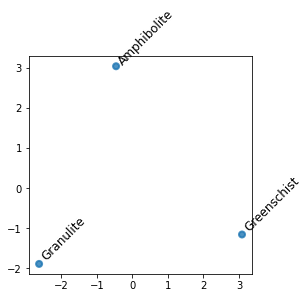

(3, 2)

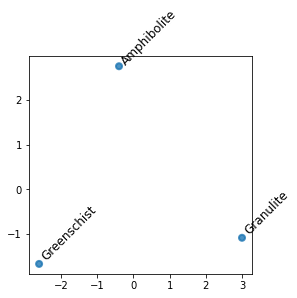

In [112]:
i = 9
l = ltype_relatedness.iloc[i,:].l
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=4, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0])
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=4, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0])
plt.show()

['Slate', 'Phyllite', 'Schist']


(3, 2)

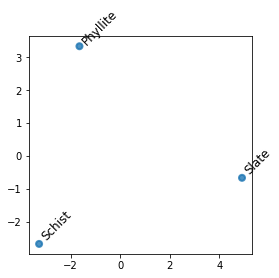

(3, 2)

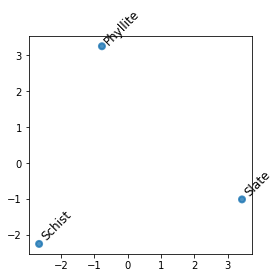

In [111]:
i = 10
l = ltype_relatedness.iloc[i,:].l
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=4, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0])
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=4, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0])
plt.show()

['Angular', 'Subangular', 'Subrounded', 'Rounded']


(2, 2)

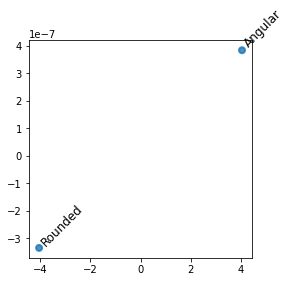

(4, 2)

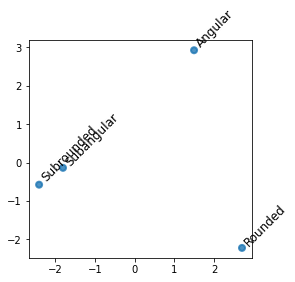

In [109]:
i = 11
l = ltype_relatedness.iloc[i,:].l
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=4, HEIGHT=4, TEXTSIZE=12, groups=[0,0])
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=4, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0,0])
plt.show()

['Boulder', 'Cobble', 'Pebble', 'Sand', 'Silt', 'Clay']


(6, 2)

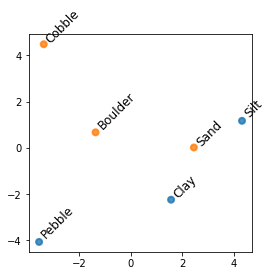

(6, 2)

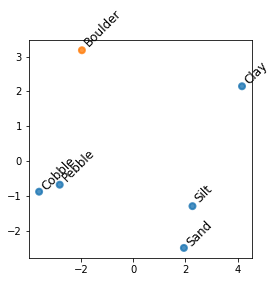

In [106]:
i = 12
l = ltype_relatedness.iloc[i,:].l
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=4, HEIGHT=4, TEXTSIZE=12, groups=[1,1,0,1,0,0])
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=4, HEIGHT=4, TEXTSIZE=12, groups=[1,0,0,0,0,0])
plt.show()

['Conglomerate', 'Sandstone', 'Siltstone', 'Mudstone']


(4, 2)

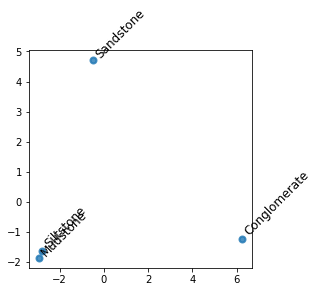

(4, 2)

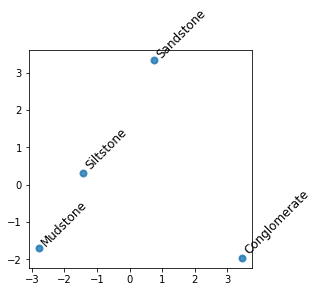

In [104]:
i = 13
l = ltype_relatedness.iloc[i,:].l
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=4, HEIGHT=4, TEXTSIZE=12)
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=4, HEIGHT=4, TEXTSIZE=12)
plt.show()

['Supergroup', 'Group', 'Subgroup', 'Formation', 'Member', 'Bed']
(300, 6)


(6, 2)

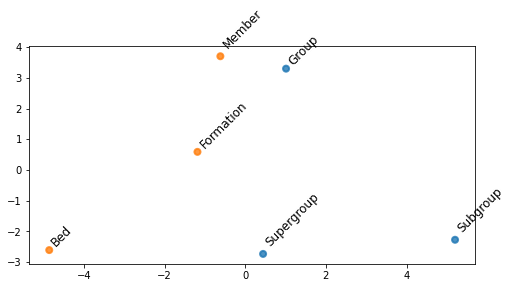

(300, 6)


(6, 2)

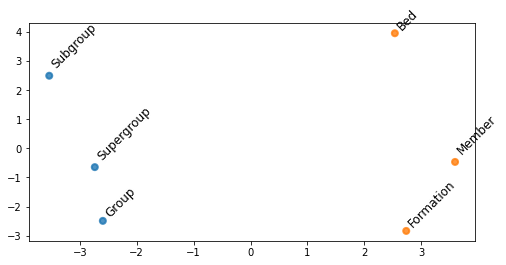

In [166]:
i = 14
l = ltype_relatedness.iloc[i,:].l
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_pretrained, WIDTH=8, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0,1,1,1])
plt.show()
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD, WIDTH=8, HEIGHT=4, TEXTSIZE=12, groups=[0,0,0,1,1,1])
plt.show()

['Hadean', 'Archean', 'Proterozoic', 'Phanerozoic']


(4, 2)

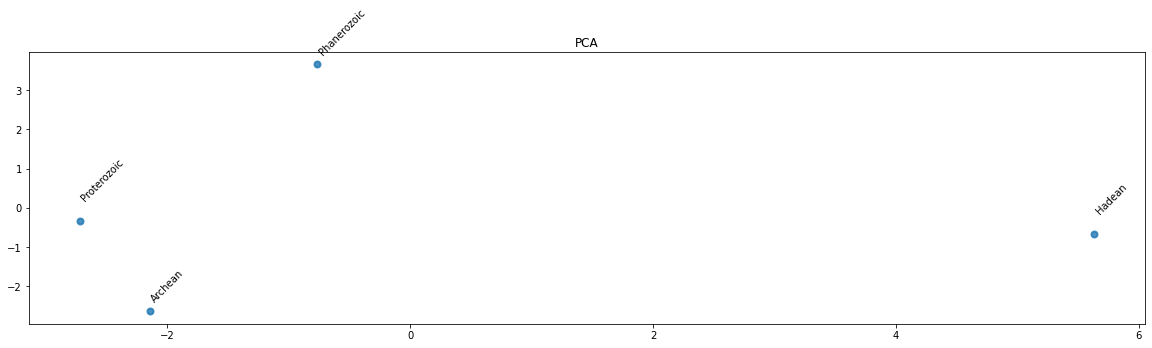

In [70]:
print(l)
show_pca_plot(l, DIMS=2, model=model_300d_PLUS_ABD)

## More nearest neighbours for a couple of special cases

Let's specifically look at the neighbours for a couple of acronyms and words with various spellings


In [189]:
nearest_neighbour_predict(model_300d_PLUS_ABD, word='vms', k=10)

,nn,similarity
0,volcanogenic,0.779715
1,sulphide,0.601093
2,polymetallic,0.554657
3,hosts,0.543193
4,hosted,0.542898
5,hosting,0.535818
6,mineralization,0.523513
7,sedex,0.520668
8,exhalative,0.498084
9,synvolcanic,0.484427


For multi-word phrases (the meaning of the acronym), we'll need to combine the word vectors. The following provides a vector sum, which is not ideal

In [195]:
result = model_300d_PLUS_ABD.most_similar(positive=['volcanogenic', 'massive', 'sulphide'], topn=10)
pd.DataFrame(result).rename(columns={0:'nn', 1:'similarity'})

,nn,similarity
0,sulphides,0.734700
1,vms,0.698237
2,mineralization,0.691380
3,hosted,0.651125
4,sulfide,0.650455
5,host,0.631103
6,stratiform,0.620851
7,felsic,0.611552
8,stratabound,0.610171
9,disseminated,0.605425


In [196]:
result = model_300d_PLUS_ABD.most_similar(positive=['volcanogenic', 'massive', 'sulfide'], topn=10)
pd.DataFrame(result).rename(columns={0:'nn', 1:'similarity'})

,nn,similarity
0,sulphide,0.814418
1,sulphides,0.678787
2,vms,0.678386
3,mineralization,0.633754
4,hosted,0.627308
5,stratiform,0.589697
6,sulfides,0.584054
7,host,0.583863
8,polymetallic,0.583529
9,stratabound,0.574333


We could equivalently sum the vectors ourselves.... Or we could replace this with averaging or any other aggregation function we like

In [205]:
vectors = [model_300d_PLUS_ABD[x] for x in ['volcanogenic', 'massive', 'sulphide']]
vectors = sum(vectors)
result = model_300d_PLUS_ABD.most_similar(positive=[vectors], topn=10)
pd.DataFrame(result).rename(columns={0:'nn', 1:'similarity'})

,nn,similarity
0,sulphide,0.892698
1,massive,0.870735
2,volcanogenic,0.850715
3,sulphides,0.738062
4,vms,0.693194
5,mineralization,0.692132
6,sulfide,0.650840
7,hosted,0.649792
8,host,0.631701
9,stratiform,0.620108


Try again for HEBS...

In [190]:
nearest_neighbour_predict(model_300d_PLUS_ABD, word='hebs', k=10)

,nn,similarity
0,pyrobitumen,0.350028
1,nick,0.340210
2,kashirsky,0.332266
3,legrena,0.319431
4,hulbert,0.316809
5,akie,0.311663
6,euxinic,0.310834
7,aurich,0.306559
8,hyper,0.298875
9,paleoredox,0.297806


In [198]:
result = model_300d_PLUS_ABD.most_similar(positive=['hyper', 'enriched', 'black', 'shales'], topn=10)
pd.DataFrame(result).rename(columns={0:'nn', 1:'similarity'})

,nn,similarity
0,shale,0.601714
1,rich,0.591412
2,dark,0.589023
3,grey,0.545491
4,carbonaceous,0.537541
5,thin,0.510958
6,red,0.508511
7,relatively,0.507370
8,green,0.502557
9,overlying,0.500975


In [206]:
vectors = [model_300d_PLUS_ABD[x] for x in ['hyper', 'enriched', 'black', 'shales']]
vectors = sum(vectors)
result = model_300d_PLUS_ABD.most_similar(positive=[vectors], topn=10)
pd.DataFrame(result).rename(columns={0:'nn', 1:'similarity'})

,nn,similarity
0,black,0.745535
1,shales,0.710365
2,shale,0.633340
3,dark,0.618285
4,enriched,0.616799
5,rich,0.588851
6,grey,0.573656
7,carbonaceous,0.551654
8,hyper,0.534407
9,thin,0.530133


Let's try a couple more words with spelling variations...

In [191]:
nearest_neighbour_predict(model_300d_PLUS_ABD, word='sulfur', k=10)

,nn,similarity
0,sulfide,0.580906
1,sulfate,0.548117
2,sulfides,0.542421
3,elemental,0.529492
4,oxygen,0.524120
5,oxidation,0.521803
6,sulphur,0.513734
7,hydrogen,0.495256
8,carbon,0.490900
9,oxidizing,0.475449


In [192]:
nearest_neighbour_predict(model_300d_PLUS_ABD, word='dyke', k=10)

,nn,similarity
0,dykes,0.794781
1,dike,0.714828
2,dikes,0.639488
3,diabase,0.613323
4,lamprophyre,0.612410
5,sill,0.596101
6,diorite,0.585835
7,swarm,0.583289
8,gabbro,0.570724
9,swarms,0.544701


In [193]:
nearest_neighbour_predict(model_300d_PLUS_ABD, word='sudbury', k=10)

,nn,similarity
0,irruptive,0.559067
1,falconbridge,0.550703
2,ontario,0.540367
3,levack,0.515925
4,onaping,0.515136
5,nickel,0.510874
6,creighton,0.508989
7,nipissing,0.500566
8,norite,0.496182
9,district,0.495535
